# Dijkstra Search

We will be trying to find and visualize the path between Equestrian Statue of Edward VII and Bahen Center of Technology around Toronto University campus using dijkstra

// This is modified version of standard Dijkstra because  
// graphs from maps have self-loops which breaks dijkstra  
// because self-loop edge could get choosen and mess our priority queue  

// when a node get removed from _unrelaxed\_nodes_ list, then this node value  
// in _shortest\_dist_ is the shortest path between the origin and that node  

__DIJKSTRA-SEARCH__( _source_ , _destination_ ) __returns__ a route  
&emsp;_shortest\_dist_ &larr; empty &emsp;// dictionary to keep the shortest distance between the origin and the node at every iteration  
&emsp;_unrelaxed\_nodes_ &larr; empty &emsp;// minimum heap based on _shortest_dist_ corresponding values to keep nodes that have not been relaxed yet  
&emsp;_seen_ &larr; empty &emsp;// to avoid self-loops which messes with our priority queue choices that lead to wrong answers  
  
&emsp;//initializing the lists  
&emsp;__for__ _node_ __in__ _graph_  
&emsp;&emsp; _shortest_dist_ \[ _node_ \] = _Infinity_  
&emsp;&emsp; __add__ _node_ __to__ _unrelaxed\_nodes_  
&emsp;&emsp; _shortest_dist_ \[ _source_ \] &larr; 0  
&emsp;&emsp; _found_ &larr; _False_    

&emsp; __while__ _unrelaxed\_nodes_ __is not__ empty __and__ _found_ __is__ _False_ __do__  
&emsp;&emsp; _node_ &larr; _unrelaxed\_nodes_.pop()  
&emsp;&emsp; __add__ _node_ __to__ _seen_  
&emsp;&emsp; __if__ _node_ __is__ _destination_ __then__  
&emsp;&emsp;&emsp; _route_ &larr; _node_.route()  
&emsp;&emsp;&emsp; _found_ &larr; _True_  
&emsp;&emsp; __for__ _child_ __in__ _node_.expand() __do__  
&emsp;&emsp;&emsp; __if__ _child_ __in__ _seen_ : __skip__  
&emsp;&emsp;&emsp; _distance_ &larr; _shortest\_dist_ \[ _node_ \] + length of edge to _child_  
&emsp;&emsp;&emsp; __if__ _distance_ &lt; _shortest\_dist_ \[ _child_ \] : &emsp;&emsp;//relax this edge  
&emsp;&emsp;&emsp;&emsp; _shortest\_dist_ \[ _child_ \] &larr; _distance_  
&emsp;&emsp;&emsp;&emsp; _child_.partent &larr; _node_  
&emsp;__return__  _route_

In [ ]:
%%capture

##############################################################################
# IGNORE if you are running on a local machine and have all the dependencies #
##############################################################################

# installing dependencies --- to be able to run on google colab
# it would take 2-3 minutes
!apt-get install libspatialindex-c4v5;
!pip3 install Rtree;
!pip3 install osmnx;
!pip3 install tqdm;
!pip3 install ipyleaflet;


# You need to upload Utilities.zip in /content directory which is the default
!unzip Utilities.zip

In [1]:
import osmnx as ox
import time, math
from collections import deque
from tqdm import tqdm
from Utilities import *

Here OSMnx find the largest connected component centered around the ```location point``` with specified ```dist``` on each side (w/n/e/s).

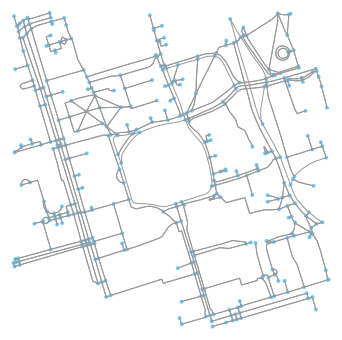

In [2]:
location_point = (43.661667, -79.395)
G = ox.graph_from_point(location_point, dist=300, clean_periphery=True, simplify=True)
graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)
fig, ax = ox.plot_graph(G)

Here you need to specify which node from our graph is the source (Equestrian Statue of Edward VII) and which is the destination node (Bahen Center of Technology). You can do so by acquiring the decimal coordinates of the desired node and use [```osmnx.distance.get_nearest_node```](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.get_nearest_node) method

I used the aforementioned method and found that the nodes for destination and source are 389677909, 55808290 respectively

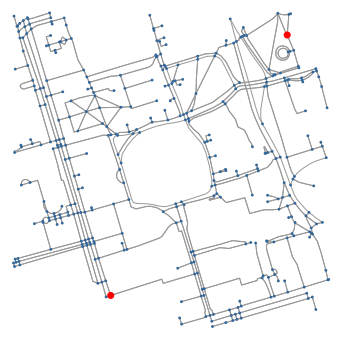

In [3]:
highlighted = [389677909, 55808290]

# marking both the source and destination node

nc = ['r' if node in highlighted else '#336699' for node in G.nodes()]
ns = [50 if node in highlighted else 8 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

In [4]:
draw_map(G, highlight = highlighted)

Map(center=[43.6618621, -79.3941032], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

Each node in our graph is represented as a dictionary so manipulating them would obfuscate the algorithm manipulating them and would be unnecessary expensive computationally <b>so</b> we define class ```Node``` only retains the data we need to be able to do searching and traversing.

Please check its source code in ```./Utilities/utils/oxm.py``` to know how it capture the data from the graph

In [5]:
%%capture
source(Node)

```Dijkstra``` algorithms expands/relaxes the node that is closest to the origin node and the distance is measured as the length of edges from that node to the origin.

So what you need in this situation is a priority queue based on the distance between each node and the origin to store those nodes and easily retrieve them.  
Luckily we can do that with normal python list and lambda functions.

# The Algorithm

In [6]:
# first define the origin/source nodes as Node
origin = Node(graph = G, osmid = 55808290)
destination = Node(graph = G, osmid = 389677909)

In [22]:
bar = tqdm(total = len(G))

# we will be dealing with the id of the nodes of the graph in our lists
# except for unrelaxed_node list where we need to have an actual `Node` object
# so we can invoke the path() function on it when we arrive at destination

seen = set()         # for dealing with self loops

shortest_dist = {osmid: math.inf for osmid in G.nodes()}
unrelaxed_nodes = [Node(graph = G, osmid = osmid) for osmid in G.nodes()]

shortest_dist[origin.osmid] = 0
found = False

while len(min_heap) > 0 and not found:
    bar.update(1); time.sleep(0.05)
    
    node = min(unrelaxed_nodes, key = lambda node : shortest_dist[node.osmid])
    
    # relaxing the node, so this node's value in shortest_dist
    # is the shortest distance between the origin and destination
    unrelaxed_nodes.remove(node)
    seen.add(node.osmid)
        
    # if the destination node has been relaxed
    # then that is the shortest path
    if node == destination:
        route = node.path()
        cost = shortest_dist[node.osmid]
        found = True
        continue
    
    # otherwise, let's relax edges of its neighbours
    for child in node.expand():
        # skip self-loops
        if child.osmid in seen: continue
        
        # we will need to get that same object from unrelaxed_nodes
        # to update it
        child_obj = next((node for node in unrelaxed_nodes if node.osmid == child.osmid), None)
        child_obj.distance = child.distance
        
        distance = shortest_dist[node.osmid] + child.distance
        if distance < shortest_dist[child_obj.osmid]:
            shortest_dist[child_obj.osmid] = distance
            child_obj.parent = node
            
bar.close()
print(f"The route is \n\n{route} \n\nits cost is\n\n{cost}")

 96%|█████████▌| 364/379 [00:18<00:00, 19.40it/s]

The route is 

[55808290, 304891685, 55808284, 1252869817, 55808239, 389678268, 4953810915, 389678267, 24960090, 389678273, 24959523, 50885177, 389677947, 2143489692, 2480712846, 389678140, 389678139, 389678138, 3707407638, 6028561924, 5098988924, 389678131, 6028562356, 854322047, 389677908, 749952029, 389677909] 

its cost is

801.4639999999999


let's visualize it on the graph

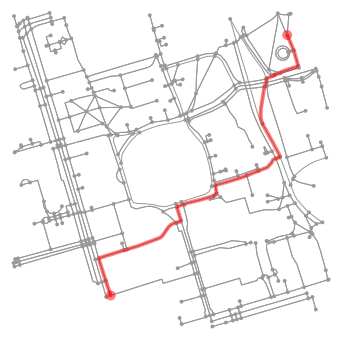

In [18]:
fig, ax = ox.plot_graph_route(G, route)

In [19]:
draw_route(G, route)

Map(center=[43.6618621, -79.3941032], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…